# **Imports**

In [ ]:
#uncomment this if you are running the notebook for the first time
#!pip install pretty_confusion_matrix
import torch
import torchvision
import torch.nn as nn  
import torch.optim as optim  
import torch.nn.functional as F  
from torch.utils.data import (
    DataLoader,
    Dataset,
) 
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve
import pandas as pd
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn.metrics import roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/dataset/val/no/531.npy  
  inflating: /content/dataset/dataset/val/no/257.npy  
  inflating: /content/dataset/dataset/val/no/243.npy  
  inflating: /content/dataset/dataset/val/no/525.npy  
  inflating: /content/dataset/dataset/val/no/1099.npy  
  inflating: /content/dataset/dataset/val/no/1927.npy  
  inflating: /content/dataset/dataset/val/no/1933.npy  
  inflating: /content/dataset/dataset/val/no/519.npy  
  inflating: /content/dataset/dataset/val/no/1066.npy  
  inflating: /content/dataset/dataset/val/no/1700.npy  
  inflating: /content/dataset/dataset/val/no/294.npy  
  inflating: /content/dataset/dataset/val/no/2209.npy  
  inflating: /content/dataset/dataset/val/no/280.npy  
  inflating: /content/dataset/dataset/val/no/1714.npy  
  inflating: /content/dataset/dataset/val/no/1072.npy  
  inflating: /content/dataset/dataset/val/no/2235.npy  
  inflating: /content/dataset/dataset/val/no/1728.npy  
  in

# **Transformation & Visualization**

In [4]:
data_transforms = transforms.Compose([
        transforms.Lambda(lambda x: x.to(torch.float32).repeat(3,1,1)),
        transforms.Resize((224,224)),
        ])


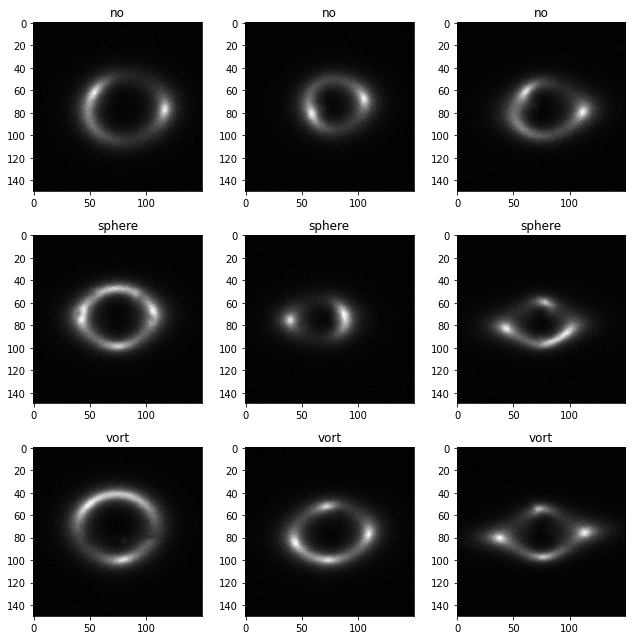

In [5]:
subfolders = ["no", "sphere", "vort"]
n_images = 3
fig = plt.figure(figsize=(9,9))
for i, subfolder in enumerate(subfolders):

    image_files = os.listdir(os.path.join("/content/dataset/dataset/train", subfolder))

    for j, image_file in enumerate(image_files[:n_images]):

        img_array = np.load(os.path.join("/content/dataset/dataset/train", subfolder, image_file))
        img = Image.fromarray((img_array[0] * 255).astype(np.uint8))
        ax = fig.add_subplot(3, 3, i*3 + j + 1)
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.set_title(subfolder)


plt.tight_layout()
plt.show()

# **Data Augmentation**

In [6]:
transform = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(100)], p=0.35),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor()
])

In [7]:
root_dir = "/content/dataset/dataset/train"
subfolders = ["no", "sphere", "vort"]
subdirs = os.listdir(root_dir)
for subdir in subfolders:
    subdir_path = os.path.join(root_dir, subdir)
    # Iterate over images
    images = os.listdir(subdir_path)
    for image in images:
        image_path = os.path.join(subdir_path, image)
        # Load image as numpy array
        image_array = np.load(image_path)
        # Convert array to float32 dtype
        image_array = np.float32(image_array)
        image_array = np.squeeze(image_array)
        # Convert array to PIL image
        pil_image = Image.fromarray(image_array)
        # Apply transform 2 times and save as new images
        for i in range(1):
            transformed_image = transform(pil_image)
            # Convert back to numpy array
            transformed_image = transformed_image.numpy()
            # Save as .npy file with a suffix
            new_image_path = image_path[:-4] + f"_{i}.npy"
            np.save(new_image_path, transformed_image)

In [8]:
dir_list = os.listdir("/content/dataset/dataset/train/no")
dir_length = len(dir_list)
print(dir_length)

20000


# **Model Definition**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.mobilenet_v3_large(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(960, 3)
)
model.to(device)

# **Data Loader**

In [14]:
def npy_loader(path):
  sample = torch.from_numpy(np.load(path))
  return sample



train_dataset = datasets.DatasetFolder(
  root='/content/dataset/dataset/train',
  loader=npy_loader,
  extensions=['.npy'],
  transform = data_transforms
)


train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = datasets.DatasetFolder(
  root='/content/dataset/dataset/val',
  loader=npy_loader,
  extensions=['.npy'],
  transform = data_transforms
)
val_dataloader = DataLoader(val_dataset, batch_size=50,shuffle=False)

# **Definitions and Helper Functions**

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [16]:
def evaluate(model, dataloader, criterion):
    losses = []
    all_targets = []
    all_scores = []
    probabilities = []
    model.eval()

    with torch.no_grad():
        for data, targets in dataloader:

            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            prob = F.softmax(scores, dim=1)
            probabilities.extend(prob.tolist())

            loss = criterion(scores, targets)

            losses.append(loss.item())
            all_targets.extend(targets.cpu().numpy())
            all_scores.extend(scores.detach().cpu().numpy())

        avg_loss = sum(losses) / len(losses)


        labels = np.array(all_targets)
        probabilities = np.array(probabilities)
        avg_auc = roc_auc_score(labels, probabilities, multi_class='ovr')

        _, preds = torch.max(torch.tensor(all_scores), 1)
        correct = (preds == torch.tensor(all_targets)).float()
        accuracy = torch.sum(correct) / len(all_targets)
        
        y_pred = preds.numpy()
        y_true = np.array(all_targets)

         

    return avg_loss, avg_auc, accuracy, y_pred, y_true

# **Model Training**

In [17]:
AUC_list = []
best_auc_val_score = 0
for epoch in range(15):
    losses = []
    all_targets = []
    all_scores = []
    probabilities = []
    # set model to training mode
    model.train()

    for data, targets in tqdm(train_loader):
      
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        prob = F.softmax(scores, dim=1)
        probabilities.extend(prob.tolist())
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_targets.extend(targets.cpu().numpy())
        all_scores.extend(scores.detach().cpu().numpy())

    avg_loss_train = sum(losses) / len(losses)


    labels = np.array(all_targets)
    probabilities = np.array(probabilities)

    avg_auc = roc_auc_score(labels, probabilities, multi_class='ovr')
    AUC_list.append(avg_auc)

    _, preds = torch.max(torch.tensor(all_scores), 1)
    correct = (preds == torch.tensor(all_targets)).float()
    accuracy = torch.sum(correct) / len(all_targets)
    

    avg_loss_test, avg_auc_test, accuracy_test, _ ,_ = evaluate(model,val_dataloader,criterion)
    scheduler.step(avg_loss_test)
    if avg_auc_test > best_auc_val_score:
            # Update the best validation score
            best_auc_val_score = avg_auc_test
            
            # Save the model state dictionary and other information
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_score': avg_auc_test
            }, 'best_model.pth')

    print(f"\nEpoch No. {epoch}\n======\n")
    print(f"Training Loss is {avg_loss_train:.5f}, Validation Loss is {avg_loss_test:.5f}")
    print(f"Training AUC is {avg_auc:.5f}, Validation AUC is {avg_auc_test:.5f}")
    print(f"Training Accuracy is {accuracy:.5f}, Validation Accuracy is{accuracy_test:.5f}")
    print("===============\n")

100%|██████████| 1200/1200 [05:37<00:00,  3.56it/s]
<ipython-input-17-9b5771463a53>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  _, preds = torch.max(torch.tensor(all_scores), 1)



Epoch No. 0

Training Loss is 0.47248, Validation Loss is 0.33415
Training AUC is 0.93537, Validation AUC is 0.97317
Training Accuracy is 0.80828, Validation Accuracy is0.87467



100%|██████████| 1200/1200 [05:56<00:00,  3.36it/s]



Epoch No. 1

Training Loss is 0.33411, Validation Loss is 0.34215
Training AUC is 0.96666, Validation AUC is 0.97239
Training Accuracy is 0.87168, Validation Accuracy is0.87387



100%|██████████| 1200/1200 [05:48<00:00,  3.44it/s]



Epoch No. 2

Training Loss is 0.27272, Validation Loss is 0.24114
Training AUC is 0.97715, Validation AUC is 0.98228
Training Accuracy is 0.89790, Validation Accuracy is0.91120



100%|██████████| 1200/1200 [05:53<00:00,  3.39it/s]



Epoch No. 3

Training Loss is 0.23436, Validation Loss is 0.43318
Training AUC is 0.98279, Validation AUC is 0.96817
Training Accuracy is 0.91317, Validation Accuracy is0.83387



100%|██████████| 1200/1200 [05:49<00:00,  3.43it/s]



Epoch No. 4

Training Loss is 0.20745, Validation Loss is 0.29637
Training AUC is 0.98622, Validation AUC is 0.97557
Training Accuracy is 0.92377, Validation Accuracy is0.89373



100%|██████████| 1200/1200 [05:49<00:00,  3.43it/s]



Epoch No. 5

Training Loss is 0.18927, Validation Loss is 0.20763
Training AUC is 0.98847, Validation AUC is 0.98810
Training Accuracy is 0.93100, Validation Accuracy is0.92947



100%|██████████| 1200/1200 [05:54<00:00,  3.38it/s]



Epoch No. 6

Training Loss is 0.16880, Validation Loss is 0.17731
Training AUC is 0.99062, Validation AUC is 0.98918
Training Accuracy is 0.93893, Validation Accuracy is0.93707



100%|██████████| 1200/1200 [05:44<00:00,  3.48it/s]



Epoch No. 7

Training Loss is 0.15602, Validation Loss is 0.19145
Training AUC is 0.99197, Validation AUC is 0.98853
Training Accuracy is 0.94330, Validation Accuracy is0.93533



100%|██████████| 1200/1200 [05:44<00:00,  3.48it/s]



Epoch No. 8

Training Loss is 0.14058, Validation Loss is 0.32920
Training AUC is 0.99341, Validation AUC is 0.97724
Training Accuracy is 0.94878, Validation Accuracy is0.89413



100%|██████████| 1200/1200 [05:47<00:00,  3.46it/s]



Epoch No. 9

Training Loss is 0.12738, Validation Loss is 0.22041
Training AUC is 0.99443, Validation AUC is 0.98583
Training Accuracy is 0.95393, Validation Accuracy is0.92707



100%|██████████| 1200/1200 [05:51<00:00,  3.41it/s]



Epoch No. 10

Training Loss is 0.11544, Validation Loss is 0.21284
Training AUC is 0.99550, Validation AUC is 0.98769
Training Accuracy is 0.95787, Validation Accuracy is0.92760



100%|██████████| 1200/1200 [05:48<00:00,  3.45it/s]



Epoch No. 11

Training Loss is 0.04884, Validation Loss is 0.17603
Training AUC is 0.99909, Validation AUC is 0.99222
Training Accuracy is 0.98390, Validation Accuracy is0.95253



100%|██████████| 1200/1200 [05:44<00:00,  3.48it/s]



Epoch No. 12

Training Loss is 0.02734, Validation Loss is 0.19823
Training AUC is 0.99963, Validation AUC is 0.99203
Training Accuracy is 0.99117, Validation Accuracy is0.95427



100%|██████████| 1200/1200 [05:44<00:00,  3.48it/s]



Epoch No. 13

Training Loss is 0.01750, Validation Loss is 0.23392
Training AUC is 0.99984, Validation AUC is 0.99087
Training Accuracy is 0.99453, Validation Accuracy is0.94707



100%|██████████| 1200/1200 [05:46<00:00,  3.46it/s]



Epoch No. 14

Training Loss is 0.01156, Validation Loss is 0.25985
Training AUC is 0.99992, Validation AUC is 0.99157
Training Accuracy is 0.99625, Validation Accuracy is0.95240



# **Loading Best Model**

In [20]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# **Testing on Test Set**

In [21]:
avg_loss_test, avg_auc_test, accuracy_test,y_pred,y_true = evaluate(model,
                                                      val_dataloader,
                                                      criterion)

print(f"\nValidation AUC score is {avg_auc_test:.5f}")
    
print(f"Validation Accuracy is {accuracy_test:.5f}")

print(f"Validation Loss is {avg_loss_test:.5f}")


Validation AUC score is 0.99222
Validation Accuracy is 0.95253
Validation Loss is 0.17603


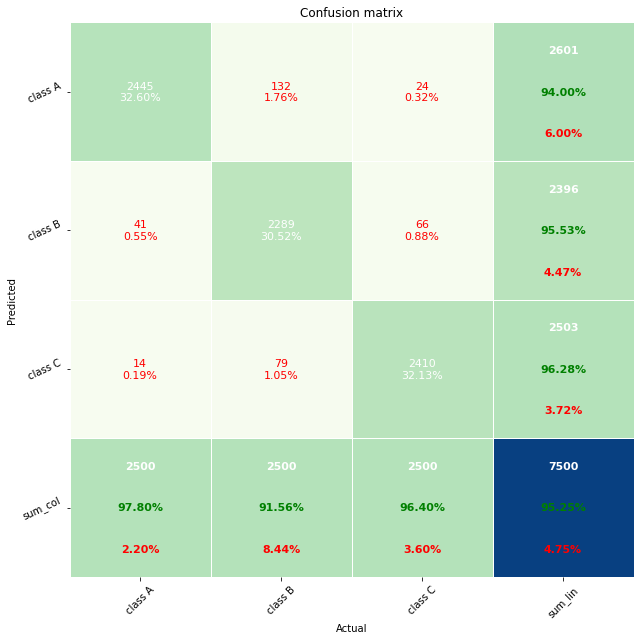

In [22]:
pp_matrix_from_data(y_true, y_pred,cmap = 'GnBu')

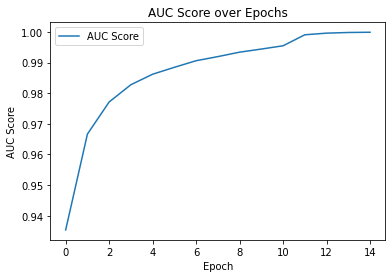

In [23]:
plt.plot(range(0, 15), AUC_list)
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC Score over Epochs")
plt.legend(["AUC Score"])

plt.show() 

# **ROC Cruve**

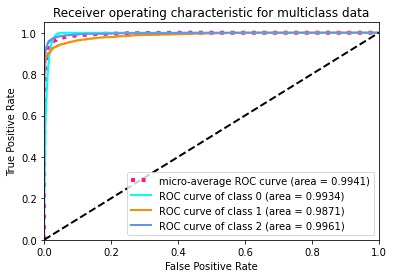

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

model.to(device)

y_score = []
y_true = []
with torch.no_grad():

    for X_batch, y_batch in val_dataloader: 
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(X_batch)
        probs = F.softmax(logits, dim=1)
        y_score.append(probs)
        y_true.append(y_batch)

y_score = torch.cat(y_score).cpu().numpy() 
y_true = torch.cat(y_true).cpu().numpy()
y_test = label_binarize(y_true, classes=[0, 1, 2]) 
n_classes = y_test.shape[1]



fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multiclass data')
plt.legend(loc="lower right")
plt.show()

In [25]:
torch.save(model.state_dict(), '/content/classification_model.pth')